In [1]:

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import datasets
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [2]:
# load the MNIST datasets
(X_train, y_train), (X_valid, y_valid) = datasets.fashion_mnist.load_data()
X_train = X_train / 255
X_valid = X_valid / 255

In [3]:
# Implementing a Stacked Autoencoder
'''
We are treating the reconstruction task as a
multilabel binary classification problem: each pixel intensity represents the prob
ability that the pixel should be black. Framing it this way (rather than as a regression
problem) tends to make the model converge faster.

'''
stacked_encoder = Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(100, activation='selu'),
    layers.Dense(30, activation='selu')
])

stacked_decoder = Sequential([
    layers.Dense(100, activation='selu', input_shape=[30]),
    layers.Dense(28 * 28, activation='sigmoid'),
    layers.Reshape([28, 28])
])

stacked_ae = Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=1.5))
history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))


Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3362 - val_loss: 0.3104
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3044 - val_loss: 0.3013
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2971 - val_loss: 0.2972
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2927 - val_loss: 0.2920
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2901 - val_loss: 0.2912
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2884 - val_loss: 0.2906
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2870 - val_loss: 0.2905
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2860 - val_loss: 0.2908
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2851 - val_loss: 0.2879
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.284

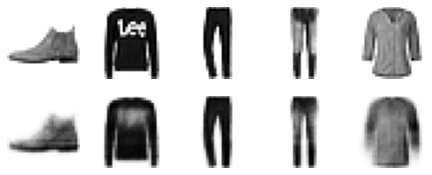

In [4]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis("off")
    
def show_reconstruction(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])       

show_reconstruction(stacked_ae) 


C:\Users\DELL\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\DELL\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


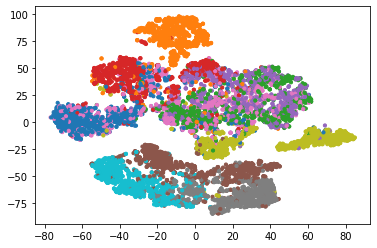

In [6]:
# used AUTOencoder for Dimensionality reduction, then TSNE for unsupervised pretraining
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')


In [11]:
# tying weights
# Class for Transposed AutoEncoder
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(
            name='bias', initializer='zeros', shape=[self.dense.input_shape[-1]]
        )
        super().build(batch_input_shape)
    
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)



# create a Layer for use in both Encoder & Decoder
dense_1 = layers.Dense(100, activation='selu')
dense_2 = layers.Dense(30, activation='selu')

tied_encoder = Sequential([
    layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    layers.Reshape([28,28])
])

tied_ae = Sequential([tied_encoder, tied_decoder])
# ...compile & fit model

Convolutional Autoencoders

In [ ]:

conv_encoder = Sequential([
    layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    layers.MaxPool2D(pool_size=2)

])

conv_decoder = Sequential([
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid', activation='selu', input_shape=[3, 3, 64]),
    layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='selu'),
    layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    layers.Reshape([28, 28])
])



Recurrent Autoencoders

In [ ]:
'''
the encoder is typically a sequence-to-vector RNN
which compresses the input sequence down to a single vector. The decoder is a
vector-to-sequence RNN that does the reverse
'''

recurrent_encoder = Sequential([
    layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    layers.LSTM(30)
])

recurrent_decoder = Sequential([
    # RepeatVector repeats the Vector N times & outputs a 3D vector
    layers.RepeatVector(28, input_shape=[30]),
    layers.LSTM(100, return_sequences=True),
    layers.TimeDistributed(layers.Dense(28, activation='sigmoid'))
])

recurrent_ae = Sequential([recurrent_encoder, recurrent_decoder])


Generative Adversial Networks

In [12]:

codings_size = 30

generator = Sequential([
    layers.Dense(100, activation='selu', input_shape=[codings_size]),
    layers.Dense(150, activation='selu'),
    layers.Dense(28 * 28, activation='sigmoid'),
    layers.Reshape([28, 28])
])

discriminator = Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(150, activation='selu'),
    layers.Dense(100, activation='selu'),
    layers.Dense(1, activation='sigmoid')
])

gan = Sequential([generator, discriminator])

discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')


In [ ]:

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)


train_gan(gan, dataset, batch_size, codings_size)

In [ ]:

X_train = X_train.reshape(-1, 28, 28, 1) * 2. -1 # reshape and rescale

codings_size = 100
generator = Sequential([
    layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    layers.Reshape([7, 7, 128]),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='selu'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')
])

discriminator = Sequential([
    layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation=layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    layers.Dropout(0.4),
    layers.Conv2D(128, kernel_size=5, strides=2, padding='same', activation=layers.LeakyReLU(0.2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

gan = Sequential([generator, discriminator])

